In [67]:
import pandas as pd 
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb



In [2]:
X = pd.read_parquet("data/train.gzip")
y = pd.read_parquet("data/train_target.gzip")

In [3]:
for column in X.columns:
    if X[column].isnull().values.any():
        print(column, X[column].isnull().sum(), X[column].isnull().sum()/X.shape[0])

In [4]:
X.columns

Index(['AEROPORT DEPART', 'AEROPORT ARRIVEE',
       'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE', 'TEMPS PROGRAMME',
       'DISTANCE', 'TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE',
       'COMPAGNIE AERIENNE', 'NOMBRE DE PASSAGERS', 'PRIX DU BARIL',
       'DEPART DE NUIT', 'ARRIVEE DE NUIT', 'DAY OF THE WEEK', 'WEEKEND',
       'MONTH', 'DAY OF THE MONTH', 'HEURE DE DEPART', 'HEURE D'ARRIVEE'],
      dtype='object')

In [5]:
X.head()

,AEROPORT DEPART,AEROPORT ARRIVEE,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS PROGRAMME,DISTANCE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,PRIX DU BARIL,DEPART DE NUIT,ARRIVEE DE NUIT,DAY OF THE WEEK,WEEKEND,MONTH,DAY OF THE MONTH,HEURE DE DEPART,HEURE D'ARRIVEE
0,CEB,AAL,0.467550,-0.995477,-0.979952,-0.241520,MAF,0.008478,1.497188,0,0,3,0,8,15,17,18
1,GOI,LTK,-0.543222,-0.149846,-0.137433,1.716964,I6F,-0.610608,-0.786430,1,0,4,0,2,11,6,9
2,DSS,JNB,-0.767838,1.434035,1.416067,-0.597608,NVPPA,3.542288,-0.791582,0,0,3,0,9,6,17,18
3,AGP,GOA,0.355242,-1.022323,-1.009923,0.648700,NVPPA,1.450781,-0.001684,1,1,6,1,5,26,23,0
4,BRU,BOD,-0.318606,2.158862,2.443408,0.114568,THA,-0.495157,-0.001684,0,0,4,0,10,11,6,14


In [6]:
y.head()

,ANNULATION,ATTERRISSAGE,DECOLLAGE,DETOURNEMENT,HEURE D'ARRIVEE,HEURE DE DEPART,RAISON D'ANNULATION,RETARD A L'ARRIVEE,RETARD AVION,RETARD COMPAGNIE,RETARD METEO,RETARD SECURITE,RETARD SYSTEM,RETART DE DEPART,TEMPS DE VOL,TEMPS PASSE,RETARD
0,0,1803.0,1718.0,0,1809.0,1658.0,None,-5.0,NaN,NaN,NaN,NaN,NaN,-9.0,45.0,71.0,0
1,0,835.0,604.0,0,852.0,553.0,None,-18.0,NaN,NaN,NaN,NaN,NaN,-7.0,91.0,119.0,0
2,0,1831.0,1756.0,0,1835.0,1747.0,None,-22.0,NaN,NaN,NaN,NaN,NaN,-2.0,215.0,228.0,0
3,0,40.0,2341.0,0,51.0,2322.0,None,45.0,6.0,0.0,15.0,0.0,24.0,21.0,59.0,89.0,1
4,0,1314.0,616.0,0,1322.0,603.0,None,-52.0,NaN,NaN,NaN,NaN,NaN,-9.0,238.0,259.0,0


In [8]:
y_retard = y[["RETARD A L'ARRIVEE"]]
y = y[["RETARD"]]
y.head()

,RETARD
0,0
1,0
2,0
3,1
4,0


In [9]:
y_retard.head()

,RETARD A L'ARRIVEE
0,-5.0
1,-18.0
2,-22.0
3,45.0
4,-52.0


In [10]:
X.columns

Index(['AEROPORT DEPART', 'AEROPORT ARRIVEE',
       'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE', 'TEMPS PROGRAMME',
       'DISTANCE', 'TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE',
       'COMPAGNIE AERIENNE', 'NOMBRE DE PASSAGERS', 'PRIX DU BARIL',
       'DEPART DE NUIT', 'ARRIVEE DE NUIT', 'DAY OF THE WEEK', 'WEEKEND',
       'MONTH', 'DAY OF THE MONTH', 'HEURE DE DEPART', 'HEURE D'ARRIVEE'],
      dtype='object')

In [11]:
X.dtypes

AEROPORT DEPART                                   object
AEROPORT ARRIVEE                                  object
TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE        float64
TEMPS PROGRAMME                                  float64
DISTANCE                                         float64
TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE    float64
COMPAGNIE AERIENNE                                object
NOMBRE DE PASSAGERS                              float64
PRIX DU BARIL                                    float64
DEPART DE NUIT                                     int64
ARRIVEE DE NUIT                                    int64
DAY OF THE WEEK                                    int64
WEEKEND                                            int64
MONTH                                              int64
DAY OF THE MONTH                                   int64
HEURE DE DEPART                                    int64
HEURE D'ARRIVEE                                    int64
dtype: object

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
cat_features = [0,1,6,10,12,13,14,15]

In [14]:
sum_neg = y_train[y_train["RETARD"]==0].shape[0]
sum_pos = y_train[y_train["RETARD"]==1].shape[0]

In [24]:
model = CatBoostClassifier(iterations=500, 
                           learning_rate=0.03, 
                           eval_metric="Recall",
                           depth=10,
                           random_seed=0, 
                           auto_class_weights="Balanced")

In [25]:
model.fit(X_train, y_train, cat_features)
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

0:	learn: 0.5994114	total: 3.4s	remaining: 28m 19s
1:	learn: 0.5975596	total: 5.85s	remaining: 24m 17s
2:	learn: 0.6138462	total: 8.75s	remaining: 24m 10s
3:	learn: 0.6157745	total: 11.7s	remaining: 24m 10s
4:	learn: 0.6331742	total: 14.7s	remaining: 24m 18s
5:	learn: 0.6347073	total: 17.6s	remaining: 24m 12s
6:	learn: 0.6295263	total: 20.7s	remaining: 24m 20s
7:	learn: 0.6372874	total: 23.8s	remaining: 24m 23s
8:	learn: 0.6412683	total: 26.8s	remaining: 24m 24s
9:	learn: 0.6416752	total: 29.9s	remaining: 24m 26s
10:	learn: 0.6408860	total: 34.1s	remaining: 25m 16s
11:	learn: 0.6405258	total: 38.3s	remaining: 25m 57s
12:	learn: 0.6411594	total: 43s	remaining: 26m 51s
13:	learn: 0.6415275	total: 48.9s	remaining: 28m 18s
14:	learn: 0.6419888	total: 53.2s	remaining: 28m 39s
15:	learn: 0.6408173	total: 56.3s	remaining: 28m 23s
16:	learn: 0.6406748	total: 1m	remaining: 28m 34s
17:	learn: 0.6430761	total: 1m 4s	remaining: 28m 51s
18:	learn: 0.6425072	total: 1m 10s	remaining: 29m 33s
19:	lear

153:	learn: 0.6725936	total: 9m 4s	remaining: 20m 22s
154:	learn: 0.6725975	total: 9m 7s	remaining: 20m 18s
155:	learn: 0.6725703	total: 9m 10s	remaining: 20m 13s
156:	learn: 0.6726597	total: 9m 13s	remaining: 20m 10s
157:	learn: 0.6727076	total: 9m 17s	remaining: 20m 6s
158:	learn: 0.6728294	total: 9m 20s	remaining: 20m 2s
159:	learn: 0.6728165	total: 9m 24s	remaining: 19m 59s
160:	learn: 0.6728994	total: 9m 28s	remaining: 19m 56s
161:	learn: 0.6729629	total: 9m 31s	remaining: 19m 53s
162:	learn: 0.6730782	total: 9m 35s	remaining: 19m 49s
163:	learn: 0.6730134	total: 9m 38s	remaining: 19m 44s
164:	learn: 0.6730782	total: 9m 42s	remaining: 19m 42s
165:	learn: 0.6731936	total: 9m 46s	remaining: 19m 39s
166:	learn: 0.6732143	total: 9m 50s	remaining: 19m 36s
167:	learn: 0.6732143	total: 9m 53s	remaining: 19m 33s
168:	learn: 0.6732065	total: 9m 56s	remaining: 19m 27s
169:	learn: 0.6732286	total: 10m	remaining: 19m 25s
170:	learn: 0.6733711	total: 10m 3s	remaining: 19m 21s
171:	learn: 0.673

301:	learn: 0.6790160	total: 17m 26s	remaining: 11m 26s
302:	learn: 0.6790769	total: 17m 30s	remaining: 11m 22s
303:	learn: 0.6790445	total: 17m 35s	remaining: 11m 20s
304:	learn: 0.6790626	total: 17m 38s	remaining: 11m 16s
305:	learn: 0.6790963	total: 17m 41s	remaining: 11m 12s
306:	learn: 0.6791067	total: 17m 44s	remaining: 11m 9s
307:	learn: 0.6791728	total: 17m 47s	remaining: 11m 5s
308:	learn: 0.6791585	total: 17m 52s	remaining: 11m 2s
309:	learn: 0.6792181	total: 17m 55s	remaining: 10m 59s
310:	learn: 0.6792311	total: 17m 59s	remaining: 10m 55s
311:	learn: 0.6792531	total: 18m 2s	remaining: 10m 52s
312:	learn: 0.6792129	total: 18m 5s	remaining: 10m 48s
313:	learn: 0.6792712	total: 18m 8s	remaining: 10m 44s
314:	learn: 0.6793646	total: 18m 11s	remaining: 10m 41s
315:	learn: 0.6793464	total: 18m 16s	remaining: 10m 38s
316:	learn: 0.6793646	total: 18m 19s	remaining: 10m 34s
317:	learn: 0.6793581	total: 18m 23s	remaining: 10m 31s
318:	learn: 0.6793477	total: 18m 26s	remaining: 10m 27

451:	learn: 0.6816894	total: 25m 32s	remaining: 2m 42s
452:	learn: 0.6817166	total: 25m 35s	remaining: 2m 39s
453:	learn: 0.6817036	total: 25m 38s	remaining: 2m 35s
454:	learn: 0.6817438	total: 25m 41s	remaining: 2m 32s
455:	learn: 0.6817373	total: 25m 43s	remaining: 2m 28s
456:	learn: 0.6817801	total: 25m 47s	remaining: 2m 25s
457:	learn: 0.6818267	total: 25m 50s	remaining: 2m 22s
458:	learn: 0.6817904	total: 25m 54s	remaining: 2m 18s
459:	learn: 0.6818799	total: 25m 57s	remaining: 2m 15s
460:	learn: 0.6819006	total: 26m	remaining: 2m 12s
461:	learn: 0.6818941	total: 26m 3s	remaining: 2m 8s
462:	learn: 0.6818786	total: 26m 5s	remaining: 2m 5s
463:	learn: 0.6819693	total: 26m 8s	remaining: 2m 1s
464:	learn: 0.6819848	total: 26m 12s	remaining: 1m 58s
465:	learn: 0.6819317	total: 26m 15s	remaining: 1m 54s
466:	learn: 0.6819680	total: 26m 18s	remaining: 1m 51s
467:	learn: 0.6819589	total: 26m 22s	remaining: 1m 48s
468:	learn: 0.6819369	total: 26m 25s	remaining: 1m 44s
469:	learn: 0.681936

In [26]:
print(classification_report(y_test, preds_class))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83    660173
           1       0.47      0.68      0.55    191970

    accuracy                           0.75    852143
   macro avg       0.68      0.73      0.69    852143
weighted avg       0.80      0.75      0.77    852143



In [27]:
print(confusion_matrix(y_test, preds_class))

[[512067 148106]
 [ 61368 130602]]


In [41]:
preds_class

array([0, 0, 0, ..., 1, 0, 0])

In [28]:
preds_proba

array([[0.89944532, 0.10055468],
       [0.8903987 , 0.1096013 ],
       [0.63712096, 0.36287904],
       ...,
       [0.44655309, 0.55344691],
       [0.84066395, 0.15933605],
       [0.88478033, 0.11521967]])

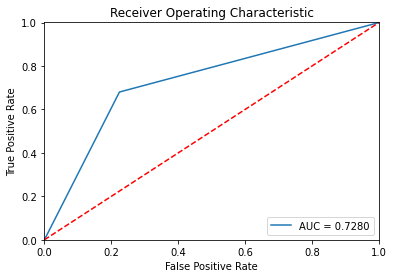

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, preds_class)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [33]:
df = pd.DataFrame()

In [34]:
df[X_test.columns] = X_test

In [48]:
predictions = []
for i in range(preds_proba.shape[0]):
    predictions.append(preds_proba[i][1])
predictions

[0.10055468375495513,
 0.10960130383915706,
 0.36287903891391166,
 0.6129654254850841,
 0.549058359776298,
 0.6066717003289702,
 0.4743045948090773,
 0.19059743860994058,
 0.1720718358847441,
 0.4878640631152383,
 0.10350198641109225,
 0.6292180213759316,
 0.34242908361091057,
 0.4799539078635892,
 0.2664377289776992,
 0.5486701480178836,
 0.14236462670223476,
 0.08861305352234251,
 0.657105447189105,
 0.19900134590815718,
 0.8667339238696853,
 0.9228505795896128,
 0.6512439623447608,
 0.4231974544217514,
 0.22324472437346393,
 0.1873918843589493,
 0.5831732701444061,
 0.41368709565256584,
 0.08801071178549329,
 0.8154724074921151,
 0.4208696095765461,
 0.17784550849208633,
 0.5785661026004438,
 0.36620841123800424,
 0.3697534003297604,
 0.28027448741860855,
 0.18904806452634662,
 0.3091699549967939,
 0.26492293972652475,
 0.18911532468012482,
 0.38312517529815937,
 0.5008814265705223,
 0.26797566202800865,
 0.4905558720562479,
 0.36926574967488235,
 0.31997565547716805,
 0.23107133748

In [49]:
df["RETARD PREDIT"] = predictions
df.head()

,AEROPORT DEPART,AEROPORT ARRIVEE,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS PROGRAMME,DISTANCE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,PRIX DU BARIL,DEPART DE NUIT,ARRIVEE DE NUIT,DAY OF THE WEEK,WEEKEND,MONTH,DAY OF THE MONTH,HEURE DE DEPART,HEURE D'ARRIVEE,RETARD PREDIT,RETARD
2205204,DUB,DXB,-0.655530,0.709208,0.873258,0.826744,COA,0.055328,-0.640448,0,0,1,0,8,29,7,12,0.100555,1
3597242,SAW,KAN,-0.992454,-0.015618,-0.045855,0.292612,WKEUW,-0.282660,1.679523,1,0,2,0,8,14,6,8,0.109601,1
331773,AGP,KNH,0.018318,-0.498836,-0.528722,-0.597608,I6F,-0.501850,1.498047,0,0,5,0,8,17,10,10,0.362879,1
1990968,ISB,SXF,2.264478,-0.525682,-0.621965,-0.597608,MAF,0.000112,-0.001684,0,0,7,1,8,19,6,7,0.612965,1
3187211,SAW,JNB,-0.430914,0.991086,1.038098,-0.419564,WKEUW,-0.270948,-0.740059,0,0,2,0,6,13,11,12,0.549058,1


In [50]:
def calculate_prediction(x):
    if x <= 0.2:
        return 0
    else : 
        return 1
df["RETARD"] = df["RETARD PREDIT"].apply(lambda x: calculate_prediction(x))
df.head()

,AEROPORT DEPART,AEROPORT ARRIVEE,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS PROGRAMME,DISTANCE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,PRIX DU BARIL,DEPART DE NUIT,ARRIVEE DE NUIT,DAY OF THE WEEK,WEEKEND,MONTH,DAY OF THE MONTH,HEURE DE DEPART,HEURE D'ARRIVEE,RETARD PREDIT,RETARD
2205204,DUB,DXB,-0.655530,0.709208,0.873258,0.826744,COA,0.055328,-0.640448,0,0,1,0,8,29,7,12,0.100555,0
3597242,SAW,KAN,-0.992454,-0.015618,-0.045855,0.292612,WKEUW,-0.282660,1.679523,1,0,2,0,8,14,6,8,0.109601,0
331773,AGP,KNH,0.018318,-0.498836,-0.528722,-0.597608,I6F,-0.501850,1.498047,0,0,5,0,8,17,10,10,0.362879,1
1990968,ISB,SXF,2.264478,-0.525682,-0.621965,-0.597608,MAF,0.000112,-0.001684,0,0,7,1,8,19,6,7,0.612965,1
3187211,SAW,JNB,-0.430914,0.991086,1.038098,-0.419564,WKEUW,-0.270948,-0.740059,0,0,2,0,6,13,11,12,0.549058,1


In [51]:
print(classification_report(y_test, df["RETARD"]))

              precision    recall  f1-score   support

           0       0.96      0.23      0.37    660173
           1       0.27      0.96      0.42    191970

    accuracy                           0.39    852143
   macro avg       0.61      0.60      0.39    852143
weighted avg       0.80      0.39      0.38    852143



In [52]:
X.head()

,AEROPORT DEPART,AEROPORT ARRIVEE,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS PROGRAMME,DISTANCE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,PRIX DU BARIL,DEPART DE NUIT,ARRIVEE DE NUIT,DAY OF THE WEEK,WEEKEND,MONTH,DAY OF THE MONTH,HEURE DE DEPART,HEURE D'ARRIVEE
0,CEB,AAL,0.467550,-0.995477,-0.979952,-0.241520,MAF,0.008478,1.497188,0,0,3,0,8,15,17,18
1,GOI,LTK,-0.543222,-0.149846,-0.137433,1.716964,I6F,-0.610608,-0.786430,1,0,4,0,2,11,6,9
2,DSS,JNB,-0.767838,1.434035,1.416067,-0.597608,NVPPA,3.542288,-0.791582,0,0,3,0,9,6,17,18
3,AGP,GOA,0.355242,-1.022323,-1.009923,0.648700,NVPPA,1.450781,-0.001684,1,1,6,1,5,26,23,0
4,BRU,BOD,-0.318606,2.158862,2.443408,0.114568,THA,-0.495157,-0.001684,0,0,4,0,10,11,6,14


In [55]:
y

,RETARD
0,0
1,0
2,0
3,1
4,0
...,...
4260710,1
4260711,0
4260712,0
4260713,0


In [57]:
y_retard = y_retard[y_retard["RETARD A L'ARRIVEE"]>10]
y_retard.head()

,RETARD A L'ARRIVEE
3,45.0
5,144.0
15,158.0
21,14.0
23,22.0


In [58]:
indexes = y_retard.index

In [62]:
indexes_deleted = X.index.difference(indexes)
indexes_deleted

Int64Index([      0,       1,       2,       4,       6,       7,       8,
                  9,      10,      11,
            ...
            4260702, 4260703, 4260704, 4260705, 4260707, 4260708, 4260711,
            4260712, 4260713, 4260714],
           dtype='int64', length=3297068)

In [63]:
X_retard = X.drop(indexes_deleted)
X_retard.head()

,AEROPORT DEPART,AEROPORT ARRIVEE,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS PROGRAMME,DISTANCE,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,COMPAGNIE AERIENNE,NOMBRE DE PASSAGERS,PRIX DU BARIL,DEPART DE NUIT,ARRIVEE DE NUIT,DAY OF THE WEEK,WEEKEND,MONTH,DAY OF THE MONTH,HEURE DE DEPART,HEURE D'ARRIVEE
3,AGP,GOA,0.355242,-1.022323,-1.009923,0.648700,NVPPA,1.450781,-0.001684,1,1,6,1,5,26,23,0
5,TIA,AGP,-0.206298,1.125313,1.542611,0.114568,NVPPA,1.464167,-2.397385,0,0,3,0,2,24,15,22
15,DEL,KIX,-0.093990,-0.619641,-0.498751,0.114568,MAF,0.010151,-0.001684,0,0,7,1,7,30,11,14
21,BRE,DUR,-0.767838,0.494445,0.713412,1.182832,APSLM,-0.476752,-0.001684,0,0,7,1,1,28,13,16
23,DQM,DXB,-0.206298,0.937395,1.028108,0.826744,COA,0.077079,-0.587207,0,0,4,0,8,18,10,15


In [64]:
X_retard = X_retard.reset_index(drop=True)
y_retard = y_retard.reset_index(drop=True)

In [70]:
cat_features = [0,1,6,10,12,13,14,15]

for i in cat_features:
    X_retard.iloc[:,i] = X_retard.iloc[:,i].astype('category')

In [71]:
X_train_retard, X_test_retard, y_train_retard, y_test_retard = train_test_split(X_retard, y_retard, test_size=0.2, random_state=42)

In [72]:
clf = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

In [73]:
clf.fit(X_train_retard, y_train_retard)
preds_class = clf.predict(X_test_retard)

In [74]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_retard, preds_class))

In [81]:
mean_squared_error(y_test_retard, preds_class)

3313.938668920745

In [75]:
rmse

57.56681916625883

In [76]:
df_retard = pd.DataFrame()

In [80]:
df_retard["RETARD"] = y_test_retard["RETARD A L'ARRIVEE"]
df_retard["RETARD PREDIT"] = preds_class
df_retard.head()

,RETARD,RETARD PREDIT
429843,28.0,64.869447
951038,19.0,71.495728
481228,14.0,25.288497
538838,11.0,46.777097
23712,216.0,45.165273


In [21]:
data = Pool(data=X_train, cat_features=cat_features)
pd.DataFrame({'feature_importance': model.get_feature_importance(data), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

CatBoostError: catboost/private/libs/target/data_providers.cpp:571: Binary classification loss/metrics require label data

In [79]:
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.iloc[train_index]
        test_labels = train_label.iloc[test_index]

        model = CatBoostClassifier(**params)
        model.fit(train, np.ravel(labels), cat_features=cat_dims)

        #res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
        res.append(recall(test_labels, model.predict(test)))
    return np.mean(res)

In [80]:
params ={'learning_rate': 0.03,
        'depth': 10,
        'iterations': 1000, 
        'random_seed': 0, 
        'auto_class_weights': "Balanced"}

In [81]:
crossvaltest(params, X, y, cat_features)

0:	learn: 0.6874978	total: 1.82s	remaining: 30m 14s
1:	learn: 0.6822036	total: 3.39s	remaining: 28m 13s
2:	learn: 0.6768876	total: 5.47s	remaining: 30m 18s
3:	learn: 0.6720778	total: 7.47s	remaining: 31m
4:	learn: 0.6681584	total: 9.49s	remaining: 31m 28s
5:	learn: 0.6637778	total: 11.6s	remaining: 32m
6:	learn: 0.6602677	total: 13.4s	remaining: 31m 42s
7:	learn: 0.6570226	total: 15.3s	remaining: 31m 41s
8:	learn: 0.6539612	total: 17.4s	remaining: 31m 58s
9:	learn: 0.6507426	total: 19.3s	remaining: 31m 55s
10:	learn: 0.6478915	total: 21.4s	remaining: 32m 4s
11:	learn: 0.6448865	total: 23.3s	remaining: 31m 55s
12:	learn: 0.6423267	total: 25s	remaining: 31m 40s
13:	learn: 0.6399945	total: 27.1s	remaining: 31m 51s
14:	learn: 0.6376891	total: 28.9s	remaining: 31m 38s
15:	learn: 0.6356320	total: 30.6s	remaining: 31m 24s
16:	learn: 0.6331769	total: 32.6s	remaining: 31m 24s
17:	learn: 0.6311442	total: 34.6s	remaining: 31m 25s
18:	learn: 0.6288229	total: 36.5s	remaining: 31m 25s
19:	learn: 0.6

153:	learn: 0.5574913	total: 6m 39s	remaining: 36m 35s
154:	learn: 0.5574029	total: 6m 42s	remaining: 36m 31s
155:	learn: 0.5572938	total: 6m 43s	remaining: 36m 25s
156:	learn: 0.5572110	total: 6m 46s	remaining: 36m 20s
157:	learn: 0.5570207	total: 6m 48s	remaining: 36m 15s
158:	learn: 0.5568835	total: 6m 50s	remaining: 36m 12s
159:	learn: 0.5567537	total: 6m 52s	remaining: 36m 8s
160:	learn: 0.5566021	total: 6m 55s	remaining: 36m 6s
161:	learn: 0.5565255	total: 6m 59s	remaining: 36m 8s
162:	learn: 0.5564440	total: 7m 1s	remaining: 36m 6s
163:	learn: 0.5563670	total: 7m 4s	remaining: 36m 1s
164:	learn: 0.5562864	total: 7m 6s	remaining: 35m 58s
165:	learn: 0.5561919	total: 7m 8s	remaining: 35m 54s
166:	learn: 0.5560011	total: 7m 11s	remaining: 35m 50s
167:	learn: 0.5558643	total: 7m 14s	remaining: 35m 51s
168:	learn: 0.5557515	total: 7m 16s	remaining: 35m 46s
169:	learn: 0.5555867	total: 7m 19s	remaining: 35m 43s
170:	learn: 0.5554959	total: 7m 21s	remaining: 35m 40s
171:	learn: 0.55535

302:	learn: 0.5439774	total: 12m 28s	remaining: 28m 40s
303:	learn: 0.5439222	total: 12m 30s	remaining: 28m 37s
304:	learn: 0.5438732	total: 12m 31s	remaining: 28m 32s
305:	learn: 0.5438164	total: 12m 34s	remaining: 28m 30s
306:	learn: 0.5437705	total: 12m 37s	remaining: 28m 29s
307:	learn: 0.5437274	total: 12m 41s	remaining: 28m 30s
308:	learn: 0.5436773	total: 12m 44s	remaining: 28m 28s
309:	learn: 0.5436301	total: 12m 46s	remaining: 28m 26s
310:	learn: 0.5435971	total: 12m 49s	remaining: 28m 24s
311:	learn: 0.5435542	total: 12m 52s	remaining: 28m 24s
312:	learn: 0.5435209	total: 12m 55s	remaining: 28m 23s
313:	learn: 0.5434832	total: 12m 59s	remaining: 28m 22s
314:	learn: 0.5433850	total: 13m 2s	remaining: 28m 20s
315:	learn: 0.5433472	total: 13m 5s	remaining: 28m 19s
316:	learn: 0.5433148	total: 13m 7s	remaining: 28m 17s
317:	learn: 0.5432430	total: 13m 10s	remaining: 28m 15s
318:	learn: 0.5432149	total: 13m 13s	remaining: 28m 13s
319:	learn: 0.5431585	total: 13m 16s	remaining: 28m

450:	learn: 0.5376855	total: 18m 51s	remaining: 22m 57s
451:	learn: 0.5376406	total: 18m 54s	remaining: 22m 55s
452:	learn: 0.5376056	total: 18m 58s	remaining: 22m 54s
453:	learn: 0.5375778	total: 19m	remaining: 22m 51s
454:	learn: 0.5375433	total: 19m 2s	remaining: 22m 48s
455:	learn: 0.5375030	total: 19m 4s	remaining: 22m 45s
456:	learn: 0.5374787	total: 19m 6s	remaining: 22m 42s
457:	learn: 0.5374445	total: 19m 8s	remaining: 22m 39s
458:	learn: 0.5374123	total: 19m 11s	remaining: 22m 37s
459:	learn: 0.5373846	total: 19m 13s	remaining: 22m 34s
460:	learn: 0.5373608	total: 19m 15s	remaining: 22m 31s
461:	learn: 0.5373298	total: 19m 18s	remaining: 22m 28s
462:	learn: 0.5372960	total: 19m 21s	remaining: 22m 26s
463:	learn: 0.5372728	total: 19m 23s	remaining: 22m 23s
464:	learn: 0.5372369	total: 19m 25s	remaining: 22m 20s
465:	learn: 0.5371987	total: 19m 27s	remaining: 22m 17s
466:	learn: 0.5371756	total: 19m 29s	remaining: 22m 15s
467:	learn: 0.5371527	total: 19m 32s	remaining: 22m 12s


598:	learn: 0.5330817	total: 25m 1s	remaining: 16m 45s
599:	learn: 0.5330491	total: 25m 4s	remaining: 16m 43s
600:	learn: 0.5330305	total: 25m 7s	remaining: 16m 40s
601:	learn: 0.5330045	total: 25m 10s	remaining: 16m 38s
602:	learn: 0.5329865	total: 25m 14s	remaining: 16m 37s
603:	learn: 0.5329662	total: 25m 17s	remaining: 16m 34s
604:	learn: 0.5329372	total: 25m 20s	remaining: 16m 32s
605:	learn: 0.5329145	total: 25m 23s	remaining: 16m 30s
606:	learn: 0.5328927	total: 25m 25s	remaining: 16m 27s
607:	learn: 0.5328645	total: 25m 27s	remaining: 16m 24s
608:	learn: 0.5328383	total: 25m 29s	remaining: 16m 22s
609:	learn: 0.5328088	total: 25m 31s	remaining: 16m 19s
610:	learn: 0.5327735	total: 25m 34s	remaining: 16m 16s
611:	learn: 0.5327512	total: 25m 36s	remaining: 16m 13s
612:	learn: 0.5327228	total: 25m 38s	remaining: 16m 11s
613:	learn: 0.5327015	total: 25m 40s	remaining: 16m 8s
614:	learn: 0.5326743	total: 25m 41s	remaining: 16m 5s
615:	learn: 0.5326379	total: 25m 44s	remaining: 16m 2

746:	learn: 0.5295908	total: 30m 31s	remaining: 10m 20s
747:	learn: 0.5295723	total: 30m 33s	remaining: 10m 17s
748:	learn: 0.5295517	total: 30m 35s	remaining: 10m 15s
749:	learn: 0.5295351	total: 30m 37s	remaining: 10m 12s
750:	learn: 0.5295077	total: 30m 40s	remaining: 10m 10s
751:	learn: 0.5294943	total: 30m 44s	remaining: 10m 8s
752:	learn: 0.5294647	total: 30m 47s	remaining: 10m 6s
753:	learn: 0.5294292	total: 30m 51s	remaining: 10m 3s
754:	learn: 0.5294047	total: 30m 54s	remaining: 10m 1s
755:	learn: 0.5293816	total: 30m 57s	remaining: 9m 59s
756:	learn: 0.5293619	total: 31m 1s	remaining: 9m 57s
757:	learn: 0.5293341	total: 31m 5s	remaining: 9m 55s
758:	learn: 0.5293103	total: 31m 8s	remaining: 9m 53s
759:	learn: 0.5292930	total: 31m 12s	remaining: 9m 51s
760:	learn: 0.5292594	total: 31m 16s	remaining: 9m 49s
761:	learn: 0.5292342	total: 31m 19s	remaining: 9m 47s
762:	learn: 0.5292008	total: 31m 22s	remaining: 9m 44s
763:	learn: 0.5291827	total: 31m 25s	remaining: 9m 42s
764:	lea

896:	learn: 0.5264806	total: 37m 21s	remaining: 4m 17s
897:	learn: 0.5264636	total: 37m 23s	remaining: 4m 14s
898:	learn: 0.5264384	total: 37m 25s	remaining: 4m 12s
899:	learn: 0.5264183	total: 37m 28s	remaining: 4m 9s
900:	learn: 0.5263975	total: 37m 30s	remaining: 4m 7s
901:	learn: 0.5263725	total: 37m 33s	remaining: 4m 4s
902:	learn: 0.5263542	total: 37m 35s	remaining: 4m 2s
903:	learn: 0.5263377	total: 37m 37s	remaining: 3m 59s
904:	learn: 0.5263244	total: 37m 40s	remaining: 3m 57s
905:	learn: 0.5263033	total: 37m 42s	remaining: 3m 54s
906:	learn: 0.5262732	total: 37m 45s	remaining: 3m 52s
907:	learn: 0.5262636	total: 37m 48s	remaining: 3m 49s
908:	learn: 0.5262430	total: 37m 50s	remaining: 3m 47s
909:	learn: 0.5262284	total: 37m 54s	remaining: 3m 44s
910:	learn: 0.5262036	total: 37m 56s	remaining: 3m 42s
911:	learn: 0.5261891	total: 37m 58s	remaining: 3m 39s
912:	learn: 0.5261663	total: 38m 1s	remaining: 3m 37s
913:	learn: 0.5261440	total: 38m 3s	remaining: 3m 34s
914:	learn: 0.52

NameError: name 'recall' is not defined

In [69]:
params = {'learning_rate': [0.03, 0.05, 0.1],
        'depth': [5, 10, 20],
        'iterations': [50, 100, 200, 1000], 
        'random_seed': [0], 
        'auto_class_weights': ["Balanced"]}